# 1_Preprocessing_and_unsupervised_algorithms

# Description

In this first notebook I am going to look inside each data set and obtain some information of it.
The main steps in this notebooks:
    1. Read the data.
    2. Clean the data.
    3. First Analysis of the data and normalization.
    4. PCA and Kmeans model toperform population segmentation.

# Imports

Imports to use in this notebooks process

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
from IPython.display import display

import seaborn as sns

import h2o
from h2o.estimators.xgboost import H2OXGBoostEstimator
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.impute import SimpleImputer
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklego.preprocessing import PandasTypeSelector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

sys.path.append('..')

from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

from utilities.helpers_data_cleaning import (distincts_in_col,
                                             convert_categorical,
                                             nan_in_col,
                                             read_feats,
                                             generate_synthetic_train_data,
                                             obtain_features_label,
                                             fill_categorical,
                                             split_data,
                                             plot_pca,
                                             pca_features,
                                             cast_categorical_h2o)

/home/jguijarh/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Configuration

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config InlineBackend.figure_format='retina'

# Constants

Paths to read the data provided by udacity

In [3]:
PATH_DATA_GERMANY = Path('../data/german_poblation/')
PATH_DATA_CUSTOMER = Path('../data/customers/')
PATH_DATA_MAILOUT = Path('../data/mailout/')
PATH_FEATS = Path("../data/feats/DIAS Attributes - Values 2017.xlsx")
PATH_SAVE = Path("../data/data_processed")
PAT_SAVE_PIPELINES = Path("../data/pipelines")

------------------------
# Read the data

The first step in this process is to read all the data from the different sources and check if this data have correct formats.

The data and sources to read in this project are four:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).


Read the features information to identify the categorical variables and configure the data types when I read the data 

In [5]:
features_dict = read_feats(PATH_FEATS)
features_dict_h2o = {}
for a,b in features_dict.items():
    if b=='category':
        features_dict_h2o[a] = 'enum'
    elif b == float:
        features_dict_h2o[a] = 'float'
features_dict_h2o['CLUSTER'] = 'enum'

In [7]:
df_ger_popu = pd.read_csv(PATH_DATA_GERMANY /
                          'Udacity_AZDIAS_052018.csv',
                          sep=';')

df_customers = pd.read_csv(PATH_DATA_CUSTOMER /
                           'Udacity_CUSTOMERS_052018.csv',
                           sep=';')

/home/jguijarh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_customers.iloc[:,19:21]

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,1,13
1,NaN,NaN
2,5,34
3,4,24
4,7,41
...,...,...
191647,1,14
191648,5,32
191649,4,24
191650,4,24


Analyse the columns with problems

In [10]:
(df_customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']]
 .groupby(['CAMEO_DEUG_2015','CAMEO_INTL_2015'])
 .count())

Empty DataFrame
Columns: []
Index: [(1.0, 13.0), (1.0, 14.0), (1.0, 15.0), (2.0, 12.0), (2.0, 13.0), (2.0, 14.0), (3.0, 23.0), (3.0, 24.0), (3.0, 25.0), (4.0, 22.0), (4.0, 23.0), (4.0, 24.0), (4.0, 25.0), (5.0, 31.0), (5.0, 32.0), (5.0, 33.0), (5.0, 34.0), (5.0, 35.0), (6.0, 31.0), (6.0, 35.0), (6.0, 43.0), (6.0, 44.0), (6.0, 45.0), (7.0, 41.0), (7.0, 45.0), (7.0, 54.0), (8.0, 41.0), (8.0, 51.0), (8.0, 54.0), (8.0, 55.0), (9.0, 51.0), (9.0, 52.0), (9.0, 55.0), (1, 13), (1, 14), (1, 15), (2, 12), (2, 13), (2, 14), (3, 23), (3, 24), (3, 25), (4, 22), (4, 23), (4, 24), (4, 25), (5, 31), (5, 32), (5, 33), (5, 34), (5, 35), (6, 31), (6, 35), (6, 43), (6, 44), (6, 45), (7, 41), (7, 45), (7, 54), (8, 41), (8, 51), (8, 54), (8, 55), (9, 51), (9, 52), (9, 55), (X, XX)]

[67 rows x 0 columns]

In [11]:
df_customers.sample()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
4403,4403,48659,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,2


I use the list of [-1,'X','XX'] to remove the values in the files with them and use it like NaN values.

In [13]:
df_ger_popu = pd.read_csv(PATH_DATA_GERMANY /
                          'Udacity_AZDIAS_052018.csv', 
                          dtype= features_dict,
                          na_values=[-1,'X','XX'],
                          index_col=0,
                          sep=';')

df_customers = pd.read_csv(PATH_DATA_CUSTOMER /
                           'Udacity_CUSTOMERS_052018.csv',
                           dtype= features_dict,
                           na_values=[-1,'X','XX'],
                           index_col=0,
                           sep=';')

Convert values inside categorical variables with value 0 or 0.0 to missing values.

In [7]:
df_ger_popu = convert_categorical(df_ger_popu)
df_customers = convert_categorical(df_customers)

### German population data

In [8]:
df_ger_popu.shape

(891221, 366)

In [9]:
df_ger_popu.sample(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
138156,928337,NaN,1.0,15.0,NaN,NaN,NaN,NaN,15.0,1.0,...,4.0,5.0,3.0,2.0,6.0,9.0,3.0,1,2,2
227815,350100,NaN,6.0,15.0,NaN,NaN,NaN,NaN,15.0,2.0,...,1.0,10.0,10.0,7.0,4.0,9.0,3.0,4,1,3
23350,622181,2,9.0,6.0,NaN,NaN,NaN,NaN,6.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,2.0,3,2,4
367340,769000,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.0,11.0,10.0,NaN,9.0,NaN,3,2,3
386871,913571,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,3.0,1.0,1.0,1.0,6.0,9.0,3.0,3,1,4
886579,286739,NaN,9.0,14.0,NaN,NaN,NaN,NaN,NaN,26.0,...,0.0,8.0,11.0,9.0,NaN,9.0,5.0,4,2,2
274267,265019,1,1.0,NaN,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,1.0,1.0,1.0,4.0,9.0,2.0,1,1,4
22006,769521,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,2.0,...,2.0,9.0,7.0,4.0,6.0,9.0,2.0,3,1,4
457318,522893,2,9.0,20.0,NaN,NaN,NaN,NaN,13.0,3.0,...,0.0,1.0,1.0,1.0,6.0,7.0,7.0,1,1,3
110605,943032,3,1.0,15.0,NaN,NaN,NaN,NaN,10.0,2.0,...,2.0,9.0,11.0,8.0,6.0,7.0,4.0,3,2,1


### Customers data

Data shapes

In [16]:
df_customers.shape

(191652, 369)

A sample of this data

In [17]:
df_customers.sample(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
52983,81861,2,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
34681,139793,3,1.0,13.0,NaN,NaN,NaN,NaN,12.0,NaN,...,1.0,0.0,9.0,NaN,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
149795,153776,2,1.0,19.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,5.0,9.0,1.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
60685,84228,2,1.0,0.0,NaN,NaN,NaN,NaN,8.0,3.0,...,2.0,2.0,9.0,3.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
157840,188265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,2,2
26822,62676,3,1.0,13.0,NaN,NaN,NaN,NaN,13.0,2.0,...,7.0,4.0,1.0,7.0,6,FOOD,SINGLE_BUYER,0,1,2
24757,130306,NaN,1.0,0.0,NaN,NaN,NaN,NaN,14.0,2.0,...,2.0,4.0,9.0,7.0,1,FOOD,SINGLE_BUYER,0,1,2
45577,188989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,2,1
185779,169179,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,8.0,...,3.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,2,4
24330,91705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,FOOD,SINGLE_BUYER,0,2,3


In the dataframe with the information of `df_customer` I have 3 more columns than in the one that defines the characteristics of the population in Germany `df_ger_popu`. Therefore, I will remove these three columns and be able to align both dataframes.

In [18]:
df_customers = df_customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], 
                                 inplace=False, 
                                 axis=1)

I am going to check the coincidences in the names of the features that define each of the data sets that I have read, so that they not only coincide in size but also in what each feature describes of the data.

In [19]:
german_popu_list = list(df_ger_popu.columns)
customers_list = list(df_customers.columns)

common = (set(german_popu_list) & set(customers_list))
german_popu_only = (set(german_popu_list) - set(customers_list))
customers_only = (set(customers_list) - set(german_popu_list))

print(f"Common in both data sets: {len(common)}")
print(f"Only in German population: {len(german_popu_only)}")
print(f"Only in customers: {len(customers_only)}")

german_popu_list = customers_list = common = german_popu_only = customers_only = None

Common in both data sets: 366
Only in German population: 0
Only in customers: 0


Let's check the percentage of null in each column of the data. As we have many features within the table, it is possible that we must eliminate some of them because they do not provide information, and the percentage of null in a column will not provide much value to the model.

In [20]:
df_nan_ger_popu = nan_in_col(df_ger_popu)
df_nan_customers = nan_in_col(df_customers)

From what we have observed so far in the data, we have:
- Reading of the files and type assignment according to the available attributes.
- The German population data had 3 less columns than the ones that defined arvatos' customers. To solve this, we have chosen to remove these 3 customer features and align datasets.
- We have collected the percentage of null elements that each column has in both dataframes and in the next steps we will decide if the feature will be eliminated by this percentage.

In [21]:
dict_feat = []
[dict_feat.append(a) for a, b in features_dict.items()]
print(f"Dictionary length: {len(dict_feat)}")
print(f"Common in both (dictionary and datasets): {len(set(list(df_customers.columns)) & set(dict_feat))}")

Dictionary length: 314
Common in both (dictionary and datasets): 272


In [22]:
features_data_and_dict = list(set(list(df_customers.columns)) & set(dict_feat))
h2o_final_dict = {}
for a,b in features_dict_h2o.items():
    if a in features_data_and_dict:
        h2o_final_dict[a] = features_dict_h2o[a]

features_dict_h2o['CLUSTER'] = 'enum'

## Feature importance in a synthetic model

Since I want to remove certain variables that may not be important for the model, I want to see how I can differentiate a model fed only with the features I have available in the data from `df_customers` and `df_ger_popu`. To do this I first define a basic model in which to analyze the metrics.

For this first model I will choose an XGBoost from the sklearn library.

I generate a synthetic data to analyze the population of customers, using both datasets.

In [32]:
df_synthetic = generate_synthetic_train_data(df_customers,df_ger_popu)
features, label = obtain_features_label(df_synthetic)
df_synthetic = fill_categorical(df_synthetic)
df_synthetic.to_csv(PATH_SAVE/'synthetic_df.csv',index= False)
df_synthetic = None

In [15]:
df_synthetic = generate_synthetic_train_data(df_customers,df_ger_popu)
features, label = obtain_features_label(df_synthetic)
df_synthetic = None

### H2O model

I'm going to model the first model using H2O library

In [27]:
h2o.init()

Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 48 mins
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_jguijarh_17hape
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.520 Gb
H2O_cluster_total_cores:,5
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"locked, healthy"


Read the data and features to train the model

In [28]:
#Read the synthetic data frame to train the model
# synthetic_frame = h2o.import_file(path='../data/data_processed/synthetic_df.csv',col_types = h2o_final_dict)
synthetic_frame = h2o.import_file(path='../data/data_processed/synthetic_df.csv')
label_train = label[0]
features_train = features 
synthetic_frame[label_train] = synthetic_frame[label_train].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


Define the model and train it

In [29]:
try:
    xgb_model = h2o.load_model('../data/models/model_all_variables/model_all_variables')
    train, valid, test = synthetic_frame.split_frame(ratios=[0.8,0.1])
    h2o.remove(synthetic_frame)
except:
    param_xgb = {
    "ntrees" : 40,
    "max_depth" : 4,
    "learn_rate" : 0.01,
    "sample_rate" : 0.8,
    "col_sample_rate_per_tree" : 0.8,
    "min_rows" : 3,
    "seed": 1993,
    "score_tree_interval": 10,
    "stopping_metric": 'AUCPR'
    }
    train, valid, test = synthetic_frame.split_frame(ratios=[0.7,0.15])
    h2o.remove(synthetic_frame)
    xgb_model = H2OXGBoostEstimator(**param_xgb)
    xgb_model.train(model_id = "model_all_variables",
                    x = features_train,
                    y = label_train,
                    training_frame = train,
                    validation_frame = valid)
    h2o.save_model(xgb_model, '../data/models/model_all_variables', force=True)

In [30]:
xgb_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4414495894679794: 


,,0,1,Error,Rate
0,0,590946.0,33135.0,0.0531,(33135.0/624081.0)
1,1,38218.0,95724.0,0.2853,(38218.0/133942.0)
2,Total,629164.0,128859.0,0.0941,(71353.0/758023.0)


Voy a sacar unas cuantas metricas para observar el rendimiento del modelo

In [31]:
print(f"Accuracy in train dataset: {xgb_model.model_performance(test_data=train).accuracy()[0][1]}")
print(f"Accuracy in validation dataset: {xgb_model.model_performance(test_data=valid).accuracy()[0][1]}")
print(f"Accuracy in test dataset: {xgb_model.model_performance(test_data=test).accuracy()[0][1]}")
print("------------------------------------------------------------------------")
print(f"AUC in train dataset: {xgb_model.model_performance(test_data=train).auc()}")
print(f"AUC in validation dataset: {xgb_model.model_performance(test_data=valid).auc()}")
print(f"AUC in test dataset: {xgb_model.model_performance(test_data=test).auc()}")
print("------------------------------------------------------------------------")
print(f"AUC PR in train dataset: {xgb_model.model_performance(test_data=train).aucpr()}")
print(f"AUC PR in validation dataset: {xgb_model.model_performance(test_data=valid).aucpr()}")
print(f"AUC PR in test dataset: {xgb_model.model_performance(test_data=test).aucpr()}")

Accuracy in train dataset: 0.9071242103999178
Accuracy in validation dataset: 0.907992813378173
Accuracy in test dataset: 0.906416593523352
------------------------------------------------------------------------
AUC in train dataset: 0.9217918727329355
AUC in validation dataset: 0.9230812024447561
AUC in test dataset: 0.9208960458864678
------------------------------------------------------------------------
AUC PR in train dataset: 0.7524141972852658
AUC PR in validation dataset: 0.7568867755783084
AUC PR in test dataset: 0.7472274986448205


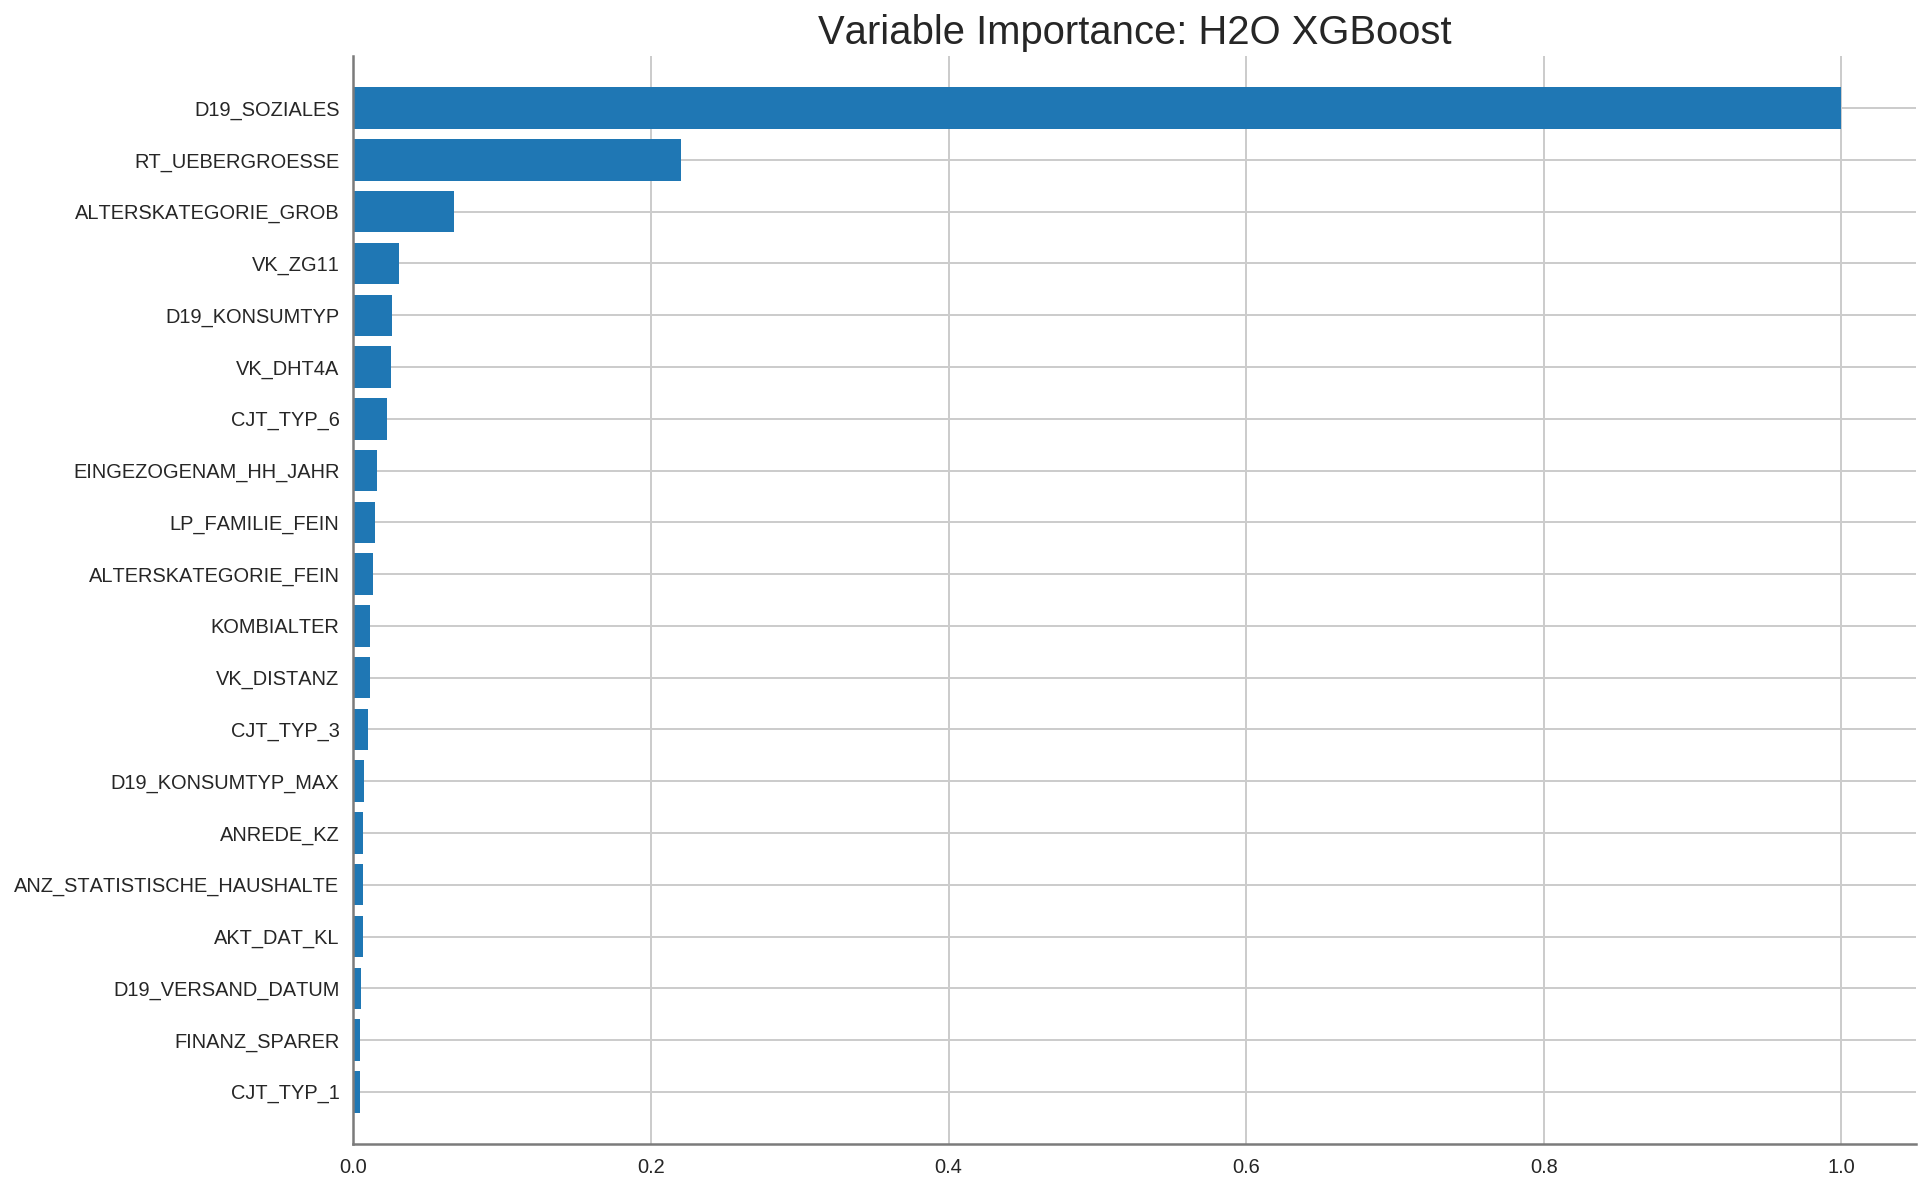

In [32]:
var_importance_model = xgb_model.varimp(use_pandas=True)
xgb_model.varimp_plot(20)

In [33]:
h2o.remove_all()

,key


-----------------------------------------
## Eliminación de columnas con alto porcentaje de nulos

Del modelo que he generado, voy a aseleccionar aquellas cuyo aporte para el modelo parece ser más alto para que si en el chequeos de futuros para eliminar features de los datos, estas se marcaran, se mantuviesen

In [34]:
most_importance_features = (var_importance_model
                            .loc[ var_importance_model['percentage']>=0.001, 
                                 'variable']
                            .tolist())
print(f"Number of columns that have more than 0.003 of importance in the model:{len(most_importance_features)}")

Number of columns that have more than 0.003 of importance in the model:28


Por lo que estas 18 columnas deberán permanecer dentro del modelo pues en un primer momento parecen ser las mas importantes para nosotros

Ahora voy a fijarme en los porcentajes de valores nulos que he extraido al principio del proceso para ver que columnas tienen un porcentaje más alto de nulos y los descartare pues no ayudan al modelo.
En la lectura de los datos se han definido una serie de elementos [0,-1,'X','XX'].

Vamos a ver de forma visual este proceso con un histograma.

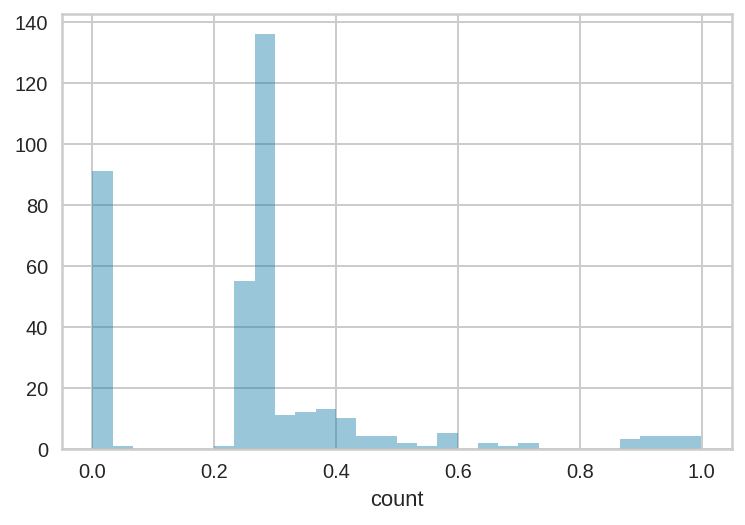

In [35]:
sns.distplot(df_nan_customers['count'],
            bins=30, kde=False, rug=False)

A la vista del histograma de features en función de los missing values que presentan, podemos elegir como un límite para eliminar variables con alta concentración de nulos el valor 0.4

In [36]:
null_limit = 0.4

# list of columns to delete by nullity
cols_with_most_nullity = (df_nan_customers
                          .loc[df_nan_customers['count']>=null_limit]['feat']
                          .tolist())
# check if some of this columns is inside of top importance columns
columns_discard_by_nullity = set(cols_with_most_nullity).difference(most_importance_features)
print(f"Features with high nullity: {len(cols_with_most_nullity)}")
print(f"Features with high nullity inside the top features: {set(cols_with_most_nullity) & set(most_importance_features)}")
columns_discard_by_nullity = list(columns_discard_by_nullity)

Features with high nullity: 46
Features with high nullity inside the top features: set()


## Generate model with less variables

In [31]:
features_train_by_nullity = []
[features_train_by_nullity.append(feat) for feat in features if feat not in columns_discard_by_nullity]
label_train = label[0]

In [32]:
#Read the synthetic data frame to train the model
synthetic_frame = h2o.import_file(path='../data/data_processed/synthetic_df.csv')
features_train_by_nullity = []
[features_train_by_nullity.append(feat) for feat in features if feat not in columns_discard_by_nullity]
label_train = label[0]
synthetic_frame[label_train] = synthetic_frame[label_train].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
try:
    xgb_model_without_null = h2o.load_model('../data/models/model_without_null_variables/model_without_null_variables')
    train, valid, test = synthetic_frame.split_frame(ratios=[0.8,0.1])
    h2o.remove(synthetic_frame)
except:
    param_xgb = {
    "ntrees" : 40,
    "max_depth" : 4,
    "learn_rate" : 0.01,
    "sample_rate" : 0.8,
    "col_sample_rate_per_tree" : 0.8,
    "min_rows" : 3,
    "seed": 1993,
    "score_tree_interval": 10,
    "stopping_metric": 'AUCPR'
    }
    train, valid, test = synthetic_frame.split_frame(ratios=[0.7,0.15])
    h2o.remove(synthetic_frame)
    xgb_model_without_null = H2OXGBoostEstimator(**param_xgb)
    xgb_model_without_null.train(model_id = "model_without_null_variables",
                    x = features_train_by_nullity,
                    y = label_train,
                    training_frame = train,
                    validation_frame = valid)
    h2o.save_model(xgb_model_without_null, '../data/models/model_without_null_variables', force=True)

In [27]:
xgb_model_without_null.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45087513448011995: 


,,0,1,Error,Rate
0,0,591977.0,32215.0,0.0516,(32215.0/624192.0)
1,1,39023.0,94961.0,0.2913,(39023.0/133984.0)
2,Total,631000.0,127176.0,0.094,(71238.0/758176.0)


Voy a sacar unas cuantas metricas para observar el rendimiento del modelo

In [28]:
print(f"Accuracy in train dataset: {xgb_model_without_null.model_performance(test_data=train).accuracy()[0][1]}")
print(f"Accuracy in validation dataset: {xgb_model_without_null.model_performance(test_data=valid).accuracy()[0][1]}")
print(f"Accuracy in test dataset: {xgb_model_without_null.model_performance(test_data=test).accuracy()[0][1]}")
print("------------------------------------------------------------------------")
print(f"AUC in train dataset: {xgb_model_without_null.model_performance(test_data=train).auc()}")
print(f"AUC in validation dataset: {xgb_model_without_null.model_performance(test_data=valid).auc()}")
print(f"AUC in test dataset: {xgb_model_without_null.model_performance(test_data=test).auc()}")
print("------------------------------------------------------------------------")
print(f"AUC PR in train dataset: {xgb_model_without_null.model_performance(test_data=train).aucpr()}")
print(f"AUC PR in validation dataset: {xgb_model_without_null.model_performance(test_data=valid).aucpr()}")
print(f"AUC PR in test dataset: {xgb_model_without_null.model_performance(test_data=test).aucpr()}")

Accuracy in train dataset: 0.9071580463950017
Accuracy in validation dataset: 0.9076863582793164
Accuracy in test dataset: 0.9081174630498561
------------------------------------------------------------------------
AUC in train dataset: 0.921698751273611
AUC in validation dataset: 0.9225910125586516
AUC in test dataset: 0.9221310217675722
------------------------------------------------------------------------
AUC PR in train dataset: 0.7511030091736854
AUC PR in validation dataset: 0.7532587389232697
AUC PR in test dataset: 0.7503496639295747


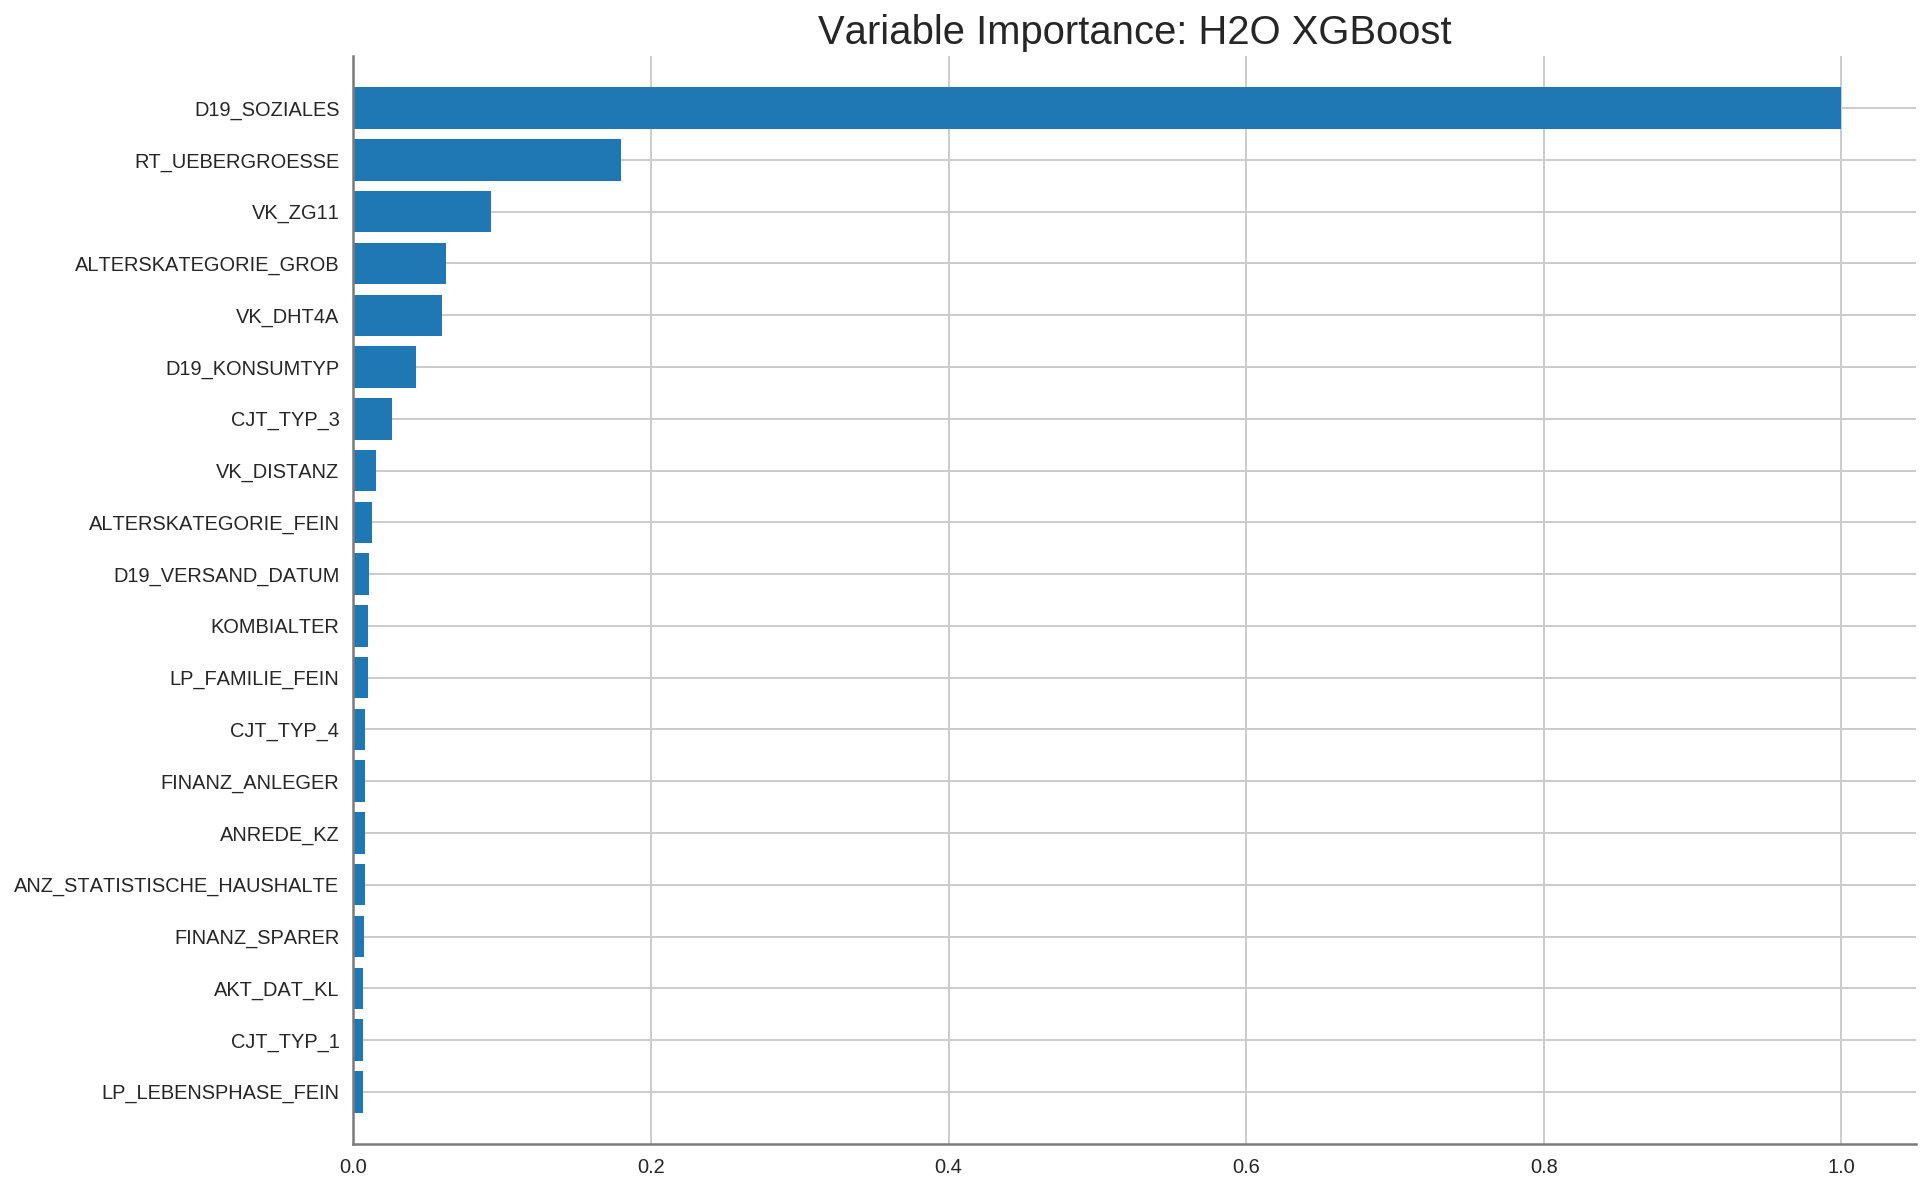

In [29]:
xgb_model_without_null.varimp_plot(20)

In [34]:
h2o.remove_all()

--------------------------------
## Unsupervised learning

I am going to train an unsupervised PCA model so that I can get what are the most important components that apply in the model and how they do it. 

For the PCA model, we have to select only those variables of numerical character, which in our data will be those that we have catalogued as numerical.

# PCA model

I get the total data taht i generated before, with the customer and population data together.

In [25]:
df_func = pd.read_csv('../data/data_processed/synthetic_new_df.csv',
                      dtype= features_dict,
                      na_values=[-1,'X','XX'])
df_func = convert_categorical(df_func)
df_func = fill_categorical(df_func)

Split the data in test and train data sets and select just the numeric columns to train the PCA and the Kmeans model

In [26]:
# Esto que sea el split data unsupervised learning en funcion

#df_func = generate_synthetic_train_data(df_customers,df_ger_popu)
features, label = obtain_features_label(df_func)
#df_func = fill_categorical(df_func)

X_train, X_test, y_train, y_test = (
    train_test_split(
        df_func[features],
        df_func[label],
        test_size=0.7,
        random_state=1993,
        stratify=df_func[label]))

X_train = X_train.select_dtypes(include='number')
X_test = X_test.select_dtypes(include='number')
X_total = df_func[features].reset_index(drop=True).select_dtypes(include='number').copy()
y_total = df_func[label].reset_index(drop=True)

Explicacion del fit que hago en el pca con mnumericas todo el dato etc etc y cque saco los train y test para el kmeans

In [27]:
# Fit to data and predict using pipeline. I fi
pipeline_pca = make_pipeline(PandasTypeSelector(include='number'),
                        SimpleImputer(strategy='constant', fill_value=-99),
                        StandardScaler(),
                        PCA(n_components=40,random_state=1993))

pipeline_pca.fit(X_total, y_total)
X_train_transformed = pipeline_pca.transform(X_train)
X_test_transformed = pipeline_pca.transform(X_test)

print(f'Explained variance ratio {pipeline_pca.named_steps["pca"].explained_variance_ratio_}')
print(f'Explained variance with the PCA: {sum(list(pipeline_pca.named_steps["pca"].explained_variance_ratio_))}')

Explained variance ratio [0.39084263 0.09193919 0.08447142 0.02462774 0.02424958 0.01885605
 0.01755789 0.01265635 0.01228594 0.01130248 0.01076505 0.01015081
 0.00994934 0.0097465  0.00959164 0.0094246  0.00925066 0.00914626
 0.00891462 0.0086725  0.00848453 0.0083085  0.00829881 0.00809759
 0.00798957 0.00771226 0.00749867 0.00739528 0.00734957 0.00726636
 0.00723121 0.00709945 0.00697077 0.0069436  0.00688446 0.00678827
 0.00668122 0.00662589 0.00656088 0.00646626]
Explained variance with the PCA: 0.9310544299754049


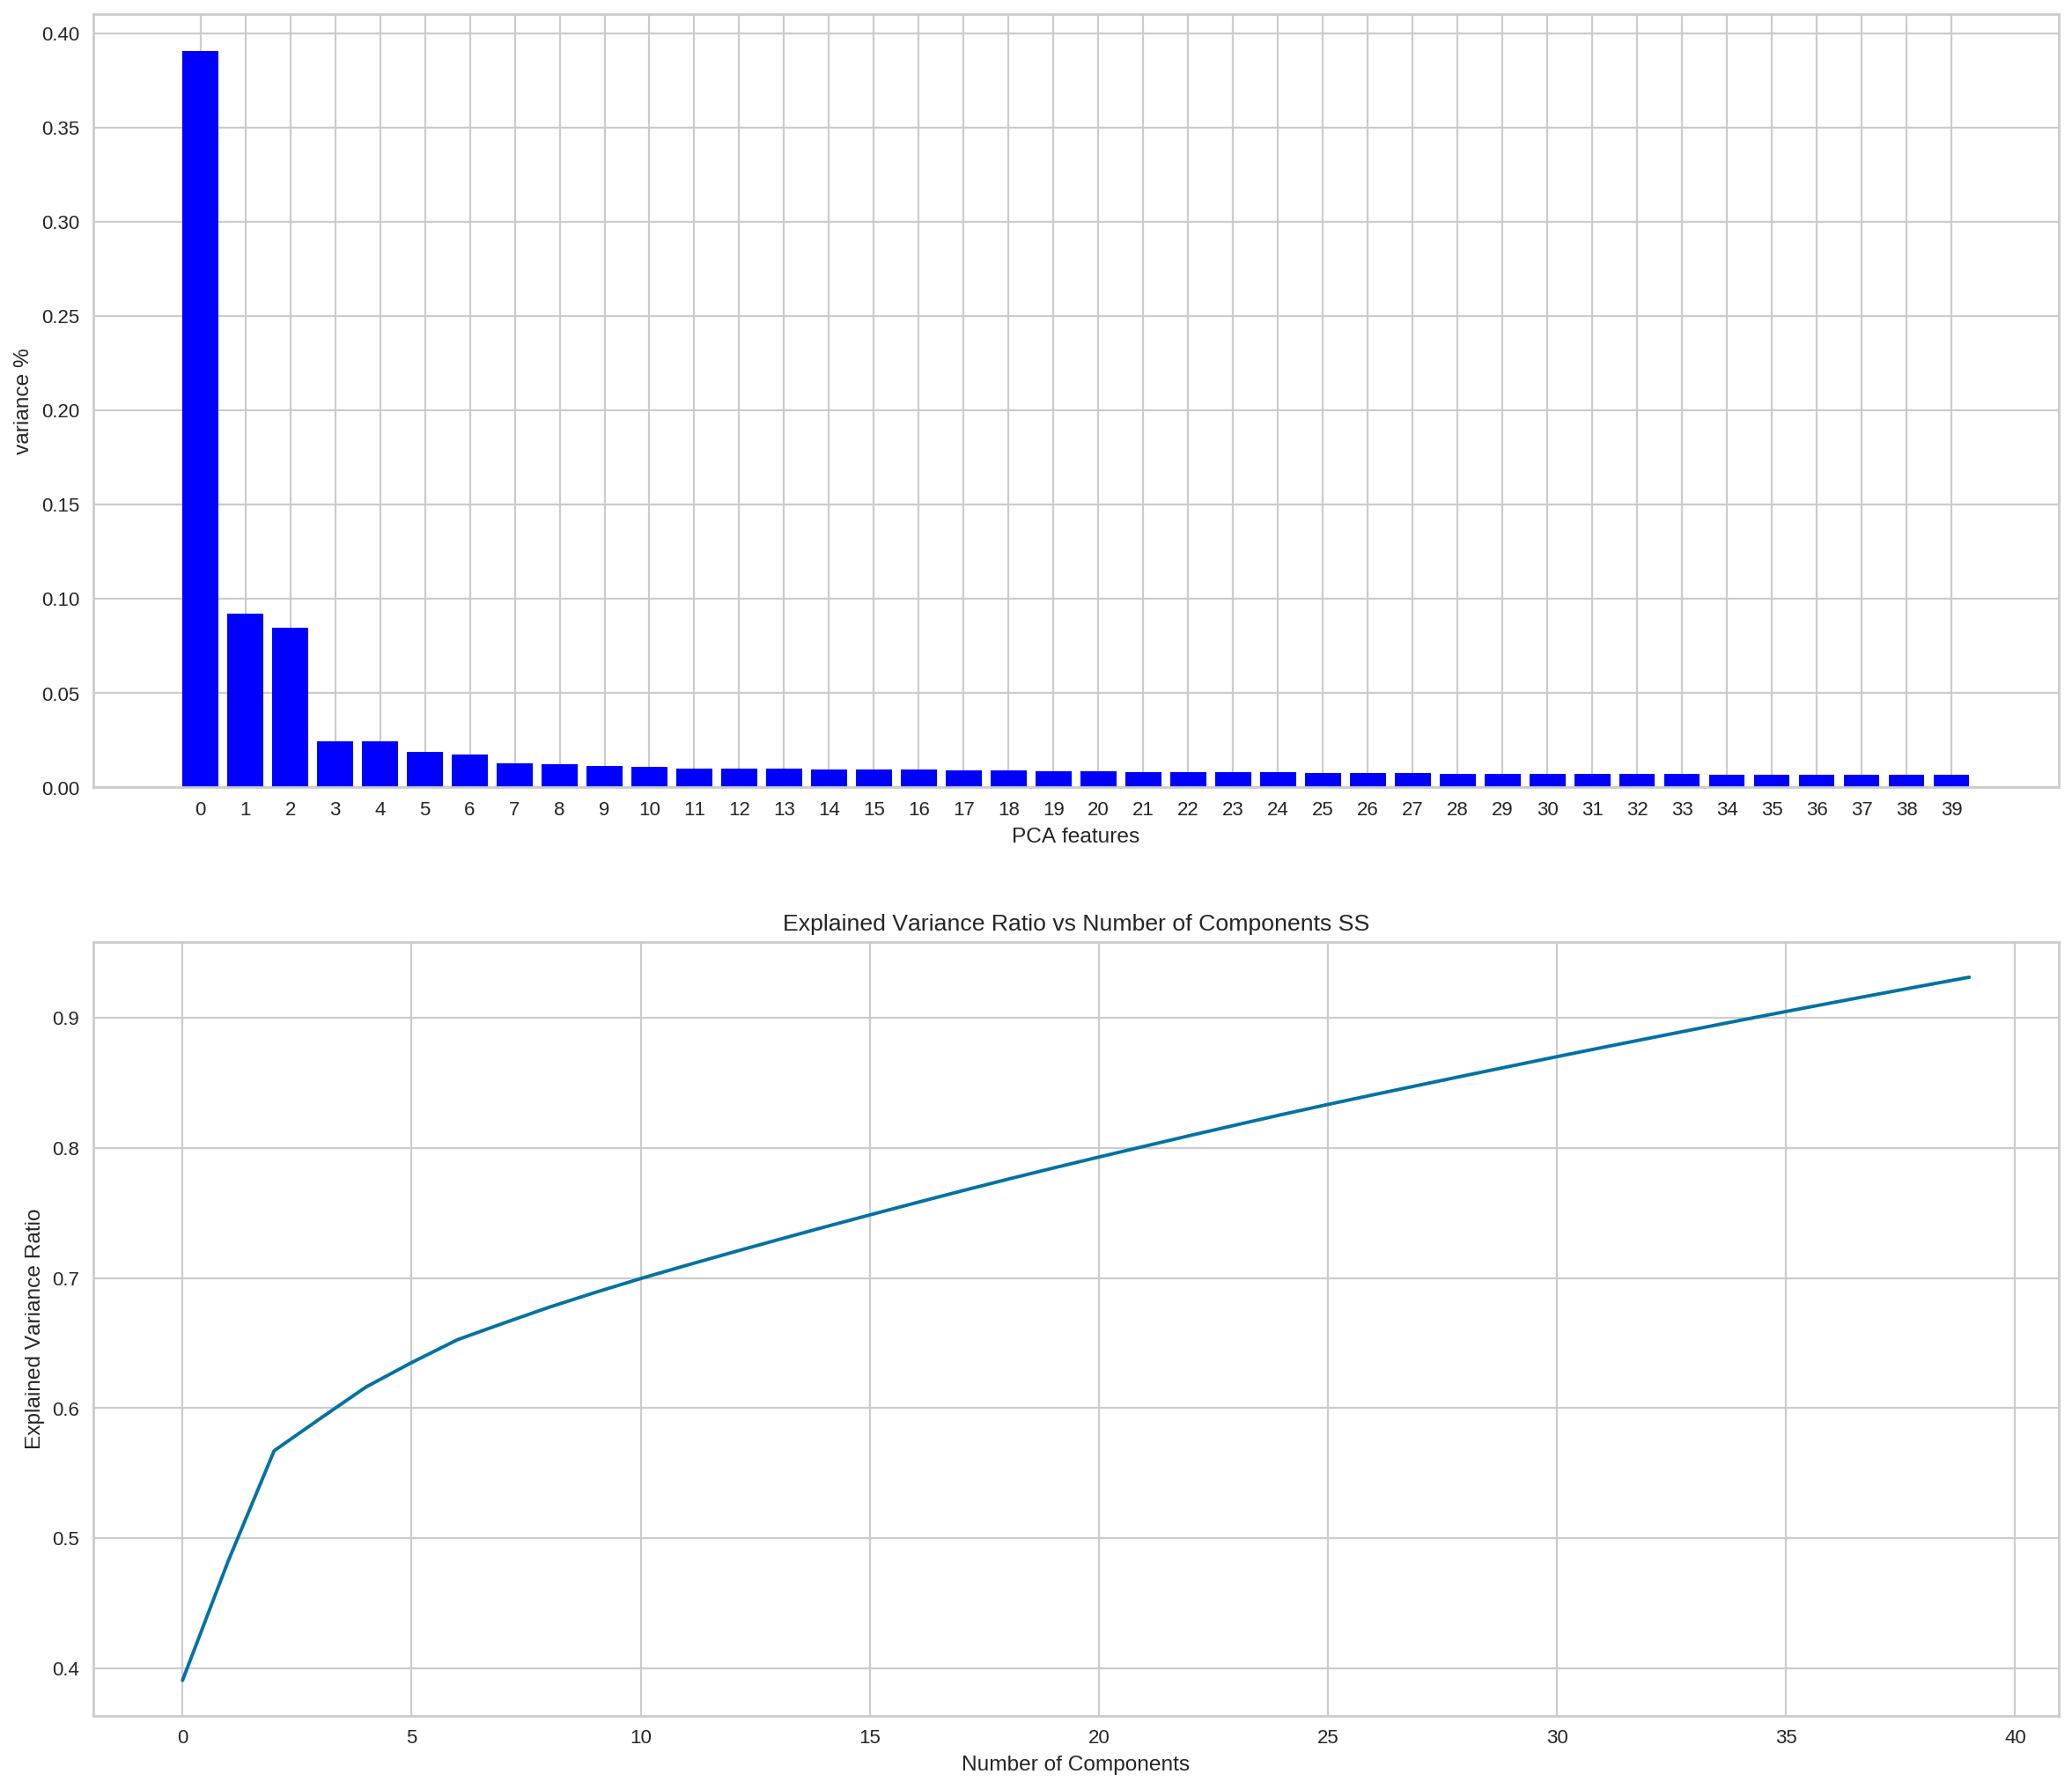

In [28]:
plot_pca(pipeline_pca.named_steps["pca"])

Explicar la interpretabilidad del PCA aqui

https://shankarmsy.github.io/posts/pca-sklearn.html

In [29]:
pca_features(X_train, pipeline_pca.named_steps["pca"], 39)

Highest: 
	D19_LOTTO            0.003
	CJT_TYP_3            0.003
	CJT_KATALOGNUTZER    0.003
	CJT_TYP_6            0.003
	VERDICHTUNGSRAUM     0.003
	FIRMENDICHTE         0.003
	UMFELD_JUNG          0.003
	GEBURTSJAHR          0.003
	VK_DISTANZ           0.003
	CAMEO_INTL_2015      0.003
	STRUKTURTYP          0.003
	CJT_TYP_4            0.004
	D19_BIO_OEKO         0.004
	ARBEIT               0.004
	VK_DHT4A             0.004
	GEMEINDETYP          0.005
	D19_BANKEN_LOKAL     0.006
	ALTERSKATEGORIE_FEIN 0.010
	D19_ENERGIE          0.011
	D19_DIGIT_SERV       0.016
	D19_FREIZEIT         0.016
	D19_VERSI_OFFLINE_DATUM 0.019
	D19_SONSTIGE         0.021
	KOMBIALTER           0.021
	D19_BANKEN_REST      0.022
	D19_VERSI_DATUM      0.024
	D19_TELKO_MOBILE     0.024
	D19_WEIN_FEINKOST    0.025
	D19_SCHUHE           0.037
	D19_HANDWERK         0.070
	ALTER_KIND4          0.072
	D19_KONSUMTYP_MAX    0.072
	D19_SAMMELARTIKEL    0.083
	D19_BEKLEIDUNG_GEH   0.147
	D19_DROGERIEARTIKEL  0.173
	D19_VE

Elbow method to take the best k (number of clusters) to use in the unsupervised algorithm Kmeans. This method iterate from k=1 to k=7 and it search the optimal k.

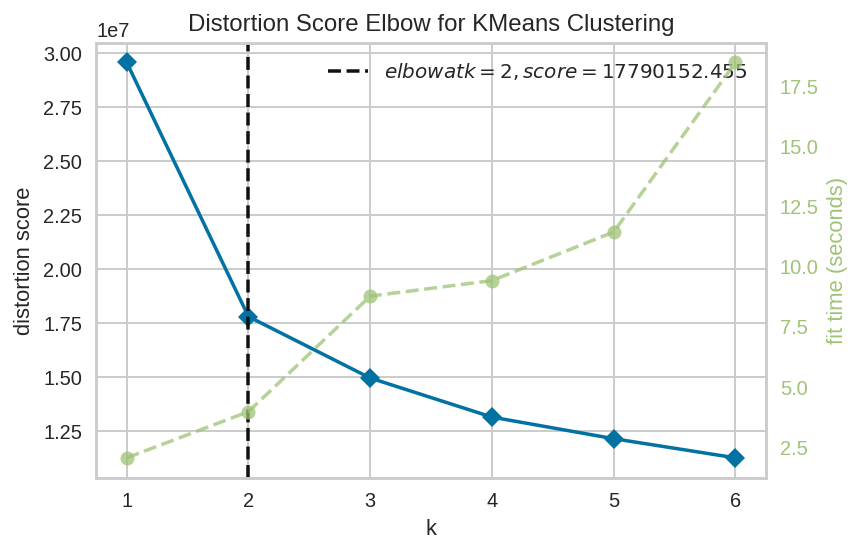

In [30]:
Kmeans_model = KMeans()
elbowMethod = KElbowVisualizer(Kmeans_model, k=(1,7))

elbowMethod.fit(X_train_transformed)
elbowMethod.show()

In this case the optimal k is k=2.

Now introduce in the pipeline the Kmeans model to apply a Kmeans of k=2 to the output converted from PCA. I fit this model with the X_train data that i preprocessed and validate that the model is not overfitted with the test data, preprocessed too.

In [31]:
pipeline_kmeans = make_pipeline(pipeline_pca,
                                KMeans(n_clusters=2, random_state=1993))

pipeline_kmeans.fit(X_train)

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('pandastypeselector',
                                  PandasTypeSelector(exclude=None,
                                                     include='number')),
                                 ('simpleimputer',
                                  SimpleImputer(add_indicator=False, copy=True,
                                                fill_value=-99,
                                                missing_values=nan,
                                                strategy='constant',
                                                verbose=0)),
                                 ('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
              

Show the two cluster generated with the model. We can see that they are perfectly separated 

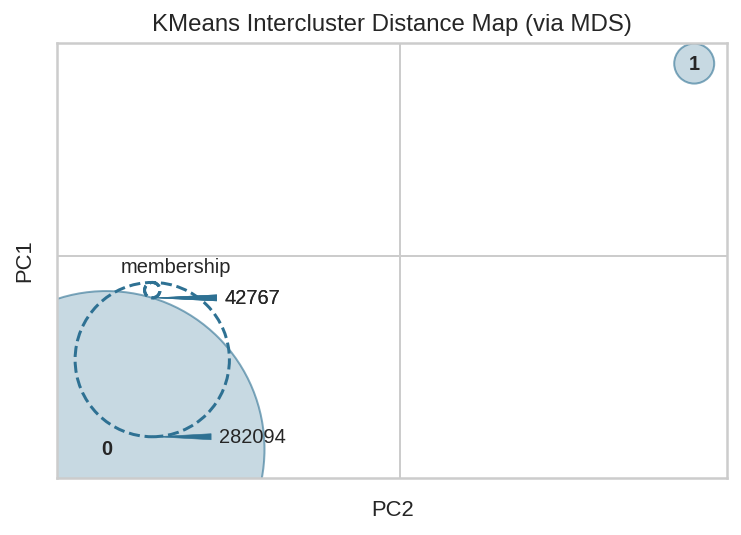

In [32]:
visualizer = InterclusterDistance(pipeline_kmeans.named_steps['kmeans'])
visualizer.fit(X_train_transformed)
visualizer.show()

Obtain the predictions that the Kmeans model have done and check the mean score that we have in the clusters

In [33]:
PCA_components_train = pd.DataFrame(X_train_transformed)
PCA_components_test = pd.DataFrame(X_test_transformed)
PCA_components_train['cluster'] = pipeline_kmeans.predict(X_train)
PCA_components_test['cluster'] = pipeline_kmeans.predict(X_test)
PCA_components_train['target'] = y_train.reset_index(drop=True)
PCA_components_test['target'] = y_test.reset_index(drop=True)

df_cluster_pipeline_train = (PCA_components_train
                             .groupby(['cluster'])
                             .agg(dict(target=['mean', 'count']))
                             .reset_index())
df_cluster_pipeline_train.columns = ['cluster', 'target_mean', 'volume']
display(df_cluster_pipeline_train
        .style
        .set_caption('Mean of the target customer in each cluster and volume in train data'))


df_cluster_pipeline_test = (PCA_components_test
                            .groupby(['cluster'])
                            .agg(dict(target=['mean', 'count']))
                            .reset_index()
                            )
df_cluster_pipeline_test.columns = ['cluster', 'target_mean', 'volume']
display(df_cluster_pipeline_test
        .style
        .set_caption('Mean of the target customer in each cluster and volume in test data'))

,cluster,target_mean,volume
0,0,0.151191,282094
1,1,0.347113,42767


,cluster,target_mean,volume
0,0,0.150638,657704
1,1,0.349743,100308


Como se puede ver en los resultados obtenidos. El modelo consigue distinguir 2 grupos en la población y en uno de ellos la media de clientes es bastante superior frente a la otra, ademas de un tamaño mucho más reducido.

Now, we save the pipelines for future process.

In [34]:
dump(pipeline_pca, PAT_SAVE_PIPELINES / 'pipeline_pca_full_variables.pkl')
dump(pipeline_kmeans, PAT_SAVE_PIPELINES / 'pipeline_kmeans_full_variables.pkl')

['../data/pipelines/pipeline_kmeans_full_variables.pkl']

# Generate final total data with unsupervised learning classification and less features 

All variables and clusters

In [119]:
# Esto que sea el split data unsupervised learning en funcion
df_func = generate_synthetic_train_data(df_customers,df_ger_popu)
features, label = obtain_features_label(df_func)
df_func = fill_categorical(df_func)
df_func['CLUSTER'] = pd.DataFrame(pipeline_kmeans.predict(X_total))
# df_func.to_csv(PATH_SAVE/'synthetic_df_with_clusters_ver_2.csv',index= False)

AttributeError: 'NoneType' object has no attribute 'copy'

In [37]:
df_func['CLUSTER'] = pd.DataFrame(pipeline_kmeans.predict(X_total))

In [40]:
df_func.to_csv(PATH_SAVE/'synthetic_df_with_clusters_ver_2.csv',index= False)

In [38]:
features_with_cluster, label_with_cluster = obtain_features_label(df_func.drop(columns=columns_discard_by_nullity))

In [81]:
df_customers = df_ger_popu = df_func = data_total_processed = X_total = y_total = X_train = X_test = PCA_components_train =df_cluster_pipeline_train = df_cluster_pipeline_test =PCA_components_test = y_train = y_test = None

---------------------------
# Generate model with less variables and with the information of the unsupervised learning

Generate the data to train

In [1]:
h2o.cluster().shutdown()

NameError: name 'h2o' is not defined

In [114]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /home/jguijarh/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpmddiyva5
  JVM stdout: /tmp/tmpmddiyva5/h2o_jguijarh_started_from_python.out
  JVM stderr: /tmp/tmpmddiyva5/h2o_jguijarh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_jguijarh_mzho01
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.746 Gb
H2O_cluster_total_cores:,5
H2O_cluster_allowed_cores:,5
H2O_cluster_status:,"accepting new members, healthy"


Read the data to train the model

In [121]:
h2o.remove_all()

In [115]:
xgb_model = h2o.load_model('../data/models/model_less_features_with_cluster/model_with_cluster')

nullity_vars = list(xgb_model.actual_params['ignored_columns'])
exclude_feats = nullity_vars + ['LNR', 'target_customer']

features_with_cluster = [feat for feat in popu_data.columns if feat not in exclude_feats]
label_with_cluster = ['target_customer']

label_train = label_with_cluster
features_train = features_with_cluster

h2o.remove_all()

AttributeError: 'NoneType' object has no attribute '_cache'

In [122]:
popu_data = h2o.import_file(path='../data/data_processed/synthetic_df_with_clusters_ver_2.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [123]:
len(popu_data.columns)

368

In [124]:
popu_data[label_train] = popu_data[label_train].asfactor()

In [120]:
#Read the synthetic data frame to train the model
popu_data = h2o.import_file(path='../data/data_processed/synthetic_df_with_clusters_ver_2.csv')
label_train = label_with_cluster
features_train = features_with_cluster

popu_data[label_train] = popu_data[label_train].asfactor()

h2o.ls()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,key
0,_bd5a94e46f688836cbf763d0f92147b5
1,model_with_cluster
2,modelmetrics_model_with_cluster@-3073519143612400064_on_py_27_sid_...
3,modelmetrics_model_with_cluster@-3073519143612400064_on_py_28_sid_...
4,synthetic_df_with_clusters_ver_2.hex


In [125]:
h2o.ls()

,key
0,synthetic_df_with_clusters_ver_2.hex


Entrenamos el modelo o cargamos el anterior si estuviera

In [126]:
try:
    xgb_model = h2o.load_model('../data/models/mssodel_less_features_with_cluster/model_with_cluster')
    train, valid, test = popu_data.split_frame(ratios=[0.7,0.15])
    h2o.remove(popu_data)
except:
    param_xgb = {
    "ntrees" : 30,
    "max_depth" : 4,
    "learn_rate" : 0.01,
    "sample_rate" : 0.8,
    "col_sample_rate_per_tree" : 0.8,
    "min_rows" : 3,
    "seed": 1993,
    "score_tree_interval": 10,
    "stopping_metric": 'AUCPR'
    }
    train, valid, test = popu_data.split_frame(ratios=[0.7,0.15])
    h2o.remove(popu_data)
    xgb_model = H2OXGBoostEstimator(**param_xgb)
    xgb_model.train(model_id = 'model_with_cluster',
                    x = features_train,
                    y = label_train[0],
                    training_frame = train,
                    validation_frame = valid)
    h2o.save_model(xgb_model, '../data/models/model_less_features_with_cluster', force=True)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [127]:
xgb_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4561319308182628: 


,,0,1,Error,Rate
0,0,606420.0,17314.0,0.0278,(17314.0/623734.0)
1,1,33000.0,100917.0,0.2464,(33000.0/133917.0)
2,Total,639420.0,118231.0,0.0664,(50314.0/757651.0)


Voy a sacar unas cuantas metricas para observar el rendimiento del modelo

In [128]:
print(f"Accuracy in train dataset: {xgb_model.model_performance(test_data=train).accuracy()[0][1]}")
print(f"Accuracy in validation dataset: {xgb_model.model_performance(test_data=valid).accuracy()[0][1]}")
print(f"Accuracy in test dataset: {xgb_model.model_performance(test_data=test).accuracy()[0][1]}")
print("------------------------------------------------------------------------")
print(f"AUC in train dataset: {xgb_model.model_performance(test_data=train).auc()}")
print(f"AUC in validation dataset: {xgb_model.model_performance(test_data=valid).auc()}")
print(f"AUC in test dataset: {xgb_model.model_performance(test_data=test).auc()}")
print("------------------------------------------------------------------------")
print(f"AUC PR in train dataset: {xgb_model.model_performance(test_data=train).aucpr()}")
print(f"AUC PR in validation dataset: {xgb_model.model_performance(test_data=valid).aucpr()}")
print(f"AUC PR in test dataset: {xgb_model.model_performance(test_data=test).aucpr()}")

Accuracy in train dataset: 0.9338415708551827
Accuracy in validation dataset: 0.9319786845647484
Accuracy in test dataset: 0.9333571248377153
------------------------------------------------------------------------
AUC in train dataset: 0.9399987000639529
AUC in validation dataset: 0.9381283779007809
AUC in test dataset: 0.9395875022663347
------------------------------------------------------------------------
AUC PR in train dataset: 0.8480402044266108
AUC PR in validation dataset: 0.84423481968757
AUC PR in test dataset: 0.8467890316254011


importancia de las variables del modelo. Se puede observar como la mejora en los resultados vistos arriba se debe en parte al resultado del preprocesado de los datos con el modelo K-means que hemos realizado con anterioridad

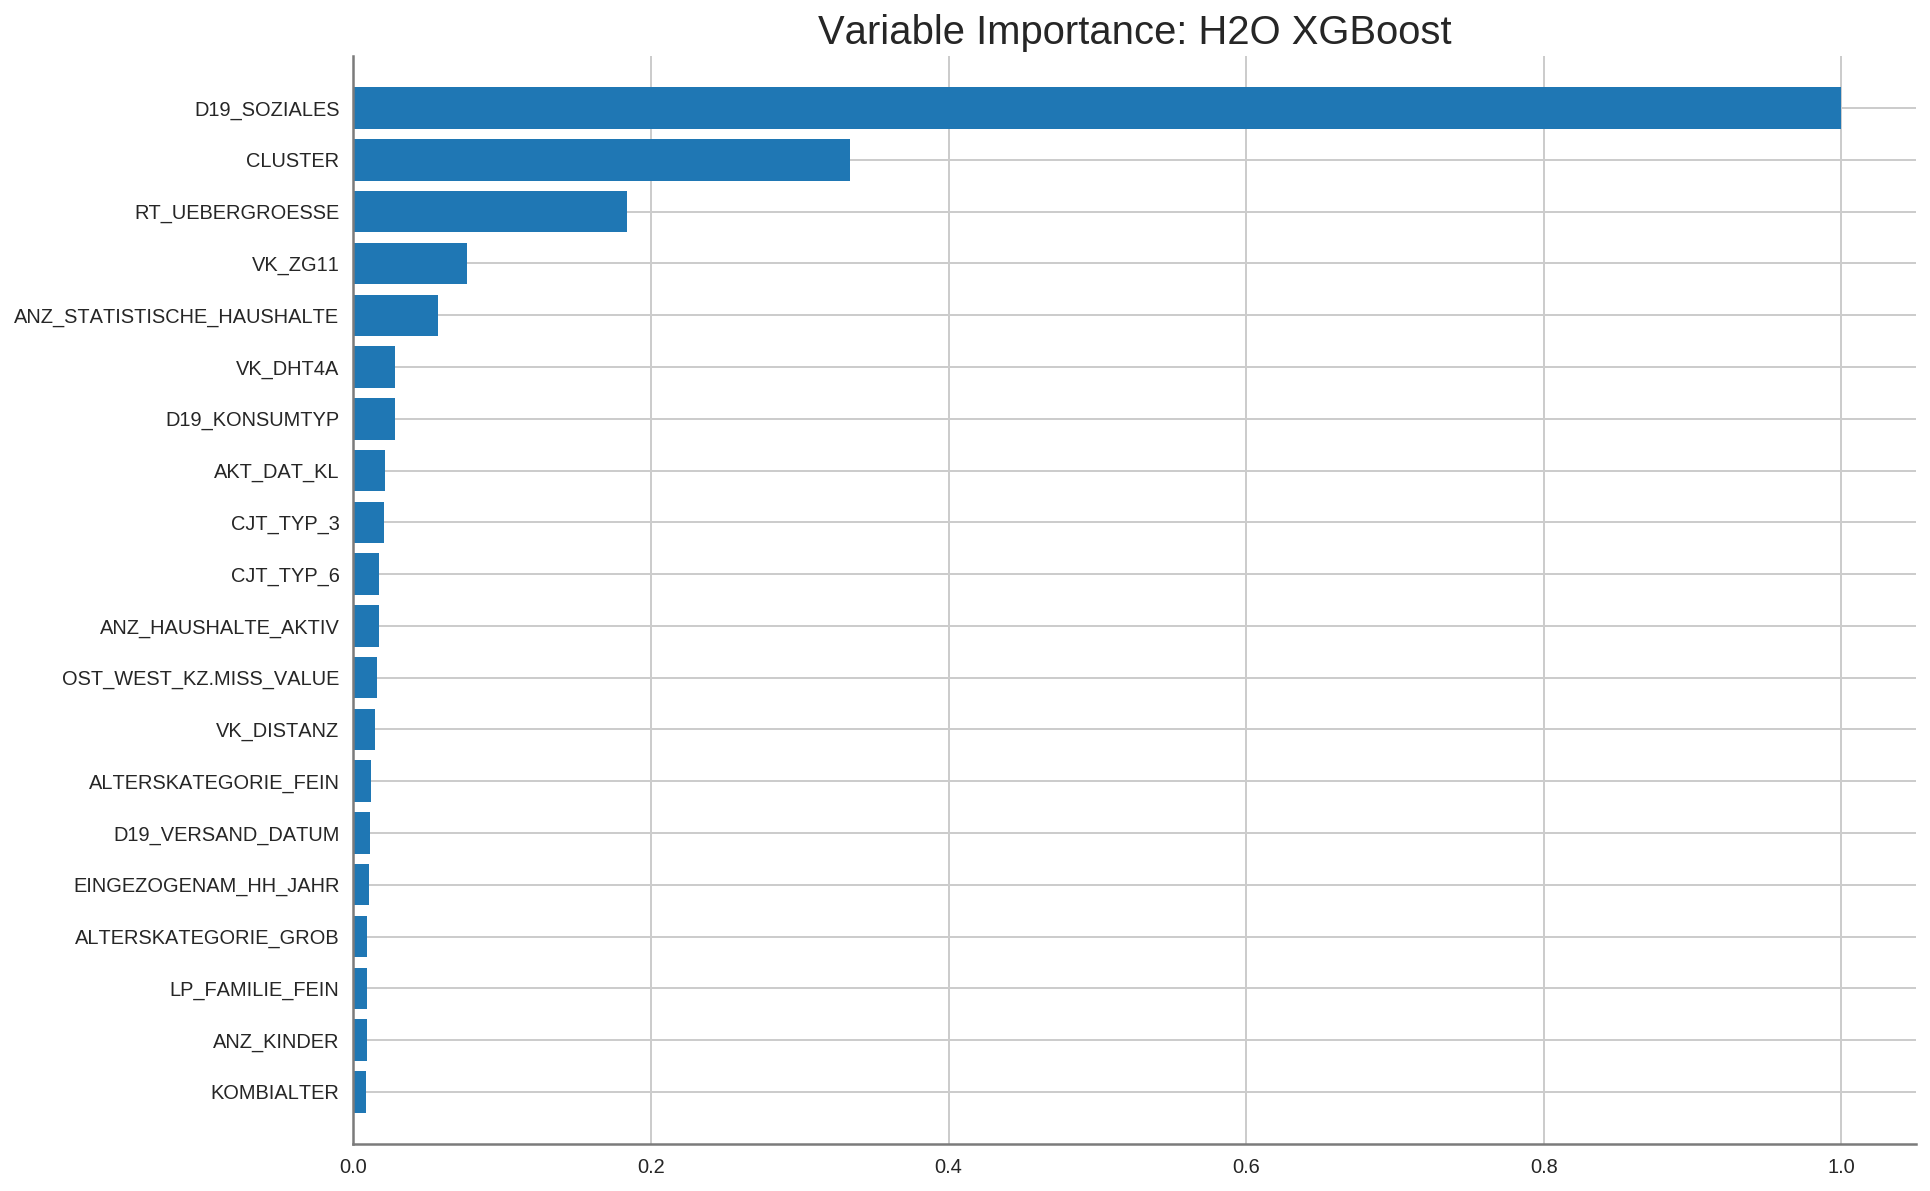

In [92]:
xgb_model.varimp_plot(20)

The model has the same performance with less variables and cluster is a really good variable

In [114]:
h2o.cluster().shutdown()

H2O session _sid_9edf closed.
